In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime
import warnings
import os

warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

%reload_ext tensorboard

In [2]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import numpy as np


In [3]:
import glob 
from collections import Counter

In [4]:
tf.test.is_built_with_cuda()

True

In [5]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

print(get_available_devices())

['/device:CPU:0', '/device:GPU:0']


In [6]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
classifier_model = mobilenet_v2


In [9]:
BATCH_SIZE = 32
SEED = 10
EPOCHES = 5

#here we have to give the path of our dataset....
TRAIN_DIR = "C:\\Users\\0MEN\\Desktop\\sub\\resizedto224\\Train\\"
VAL_DIR = "C:\\Users\\0MEN\\Desktop\\sub\\resizedto224\\Test\\"
PRED_DIR = "C:\\Users\\0MEN\\Desktop\\sub\\resizedto224\\pred\\"

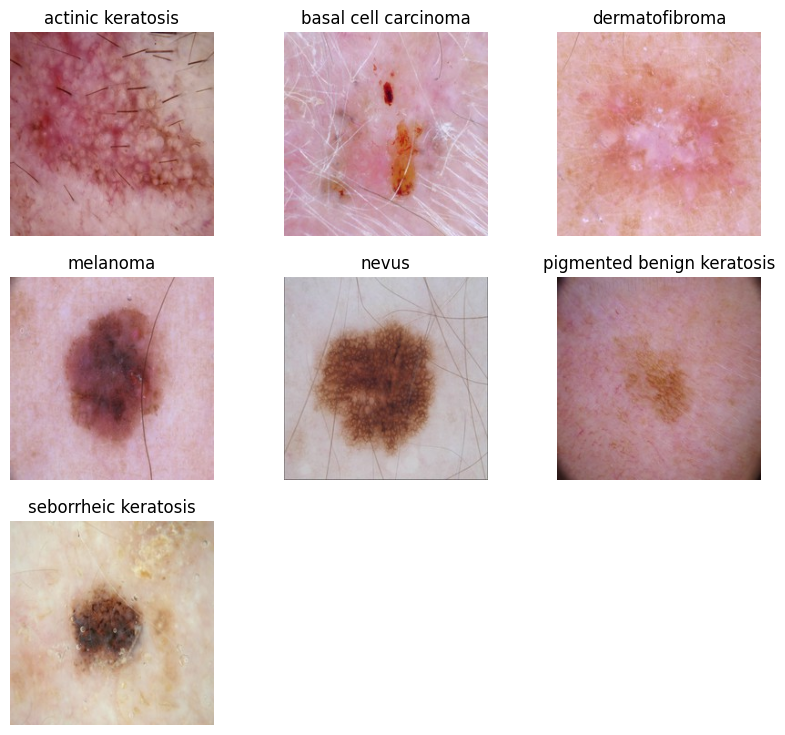

In [10]:
plt.figure(figsize=(10, 9))
for i, folder in enumerate(os.listdir(TRAIN_DIR)):
    ax = plt.subplot(3, 3, i + 1)
    img = plt.imread(TRAIN_DIR+folder +'/'+ os.listdir(TRAIN_DIR+folder)[0])
    plt.imshow(img)
    plt.title(folder)
    plt.axis("off")

In [11]:
categories, freq = [], []
for folder in os.listdir(TRAIN_DIR):
    categories.append(folder)
    freq.append(len(os.listdir(TRAIN_DIR + folder)))
    print(len(os.listdir(TRAIN_DIR + folder)), 'picture in :', folder)

114 picture in : actinic keratosis
376 picture in : basal cell carcinoma
95 picture in : dermatofibroma
438 picture in : melanoma
357 picture in : nevus
462 picture in : pigmented benign keratosis
77 picture in : seborrheic keratosis


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# train set
train_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                     brightness_range=(0.9, 1.0),
                                    horizontal_flip=True, 
                                    rotation_range=20,
                                    zoom_range=0.2, 
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2)
train_generator = train_data_gen.flow_from_directory(TRAIN_DIR,
                                                     target_size=(224, 224),
                                                     color_mode='rgb',
                                                     batch_size=BATCH_SIZE,
                                                     class_mode='categorical',
                                                     shuffle=True, 
                                                     seed=SEED)

# validation set
val_data_gen  = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_data_gen.flow_from_directory(VAL_DIR,
                                                 target_size=(224, 224),
                                                 color_mode='rgb',
                                                 batch_size=BATCH_SIZE,
                                                 class_mode='categorical',
                                                 shuffle=False,
                                                 seed=SEED)

Found 1919 images belonging to 7 classes.
Found 99 images belonging to 7 classes.


In [13]:
train_generator.class_indices

{'actinic keratosis': 0,
 'basal cell carcinoma': 1,
 'dermatofibroma': 2,
 'melanoma': 3,
 'nevus': 4,
 'pigmented benign keratosis': 5,
 'seborrheic keratosis': 6}

In [14]:
class_names = np.array(train_generator.class_indices)
print(class_names)


{'actinic keratosis': 0, 'basal cell carcinoma': 1, 'dermatofibroma': 2, 'melanoma': 3, 'nevus': 4, 'pigmented benign keratosis': 5, 'seborrheic keratosis': 6}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

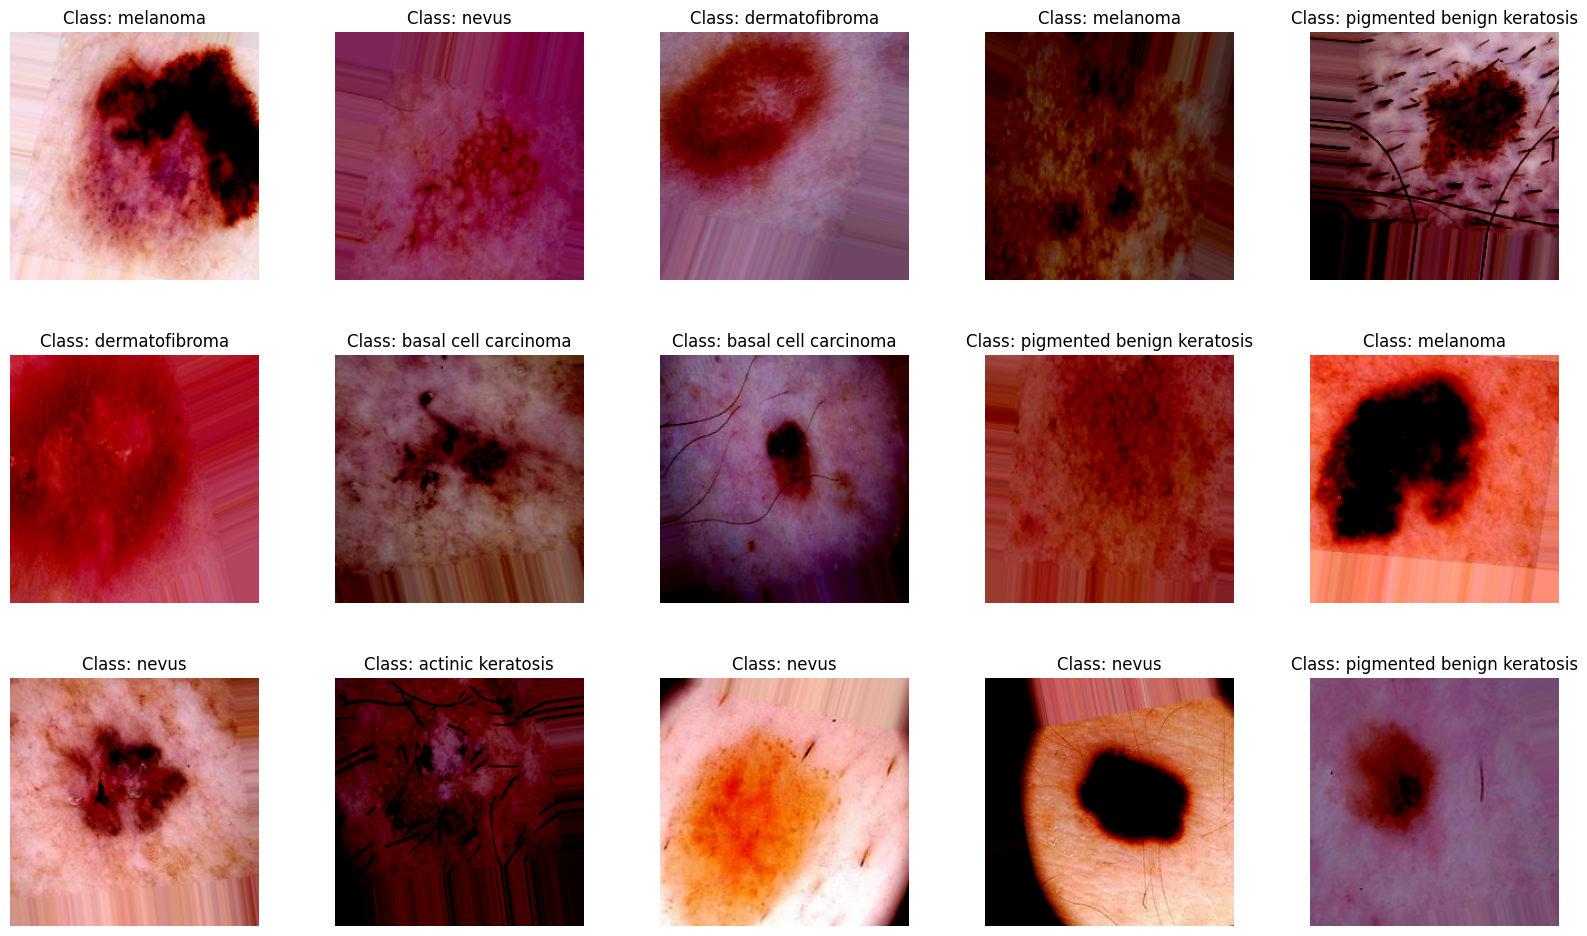

In [15]:
import numpy as np

labels = [k for k,v in train_generator.class_indices.items()]
sample_generate = train_generator.__next__()
images = sample_generate[0]
titles = sample_generate[1]

plt.figure(figsize = (20 , 20))
for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

In [16]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32, 7)


In [17]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False,
                         input_shape=(224, 224, 3))

# freeze pretrained ntework
for layer in base_model.layers:
    layer.trainable = False

In [18]:
feature_extractor_model = mobilenet_v2

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization


In [20]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization

model = Sequential([base_model,  # MobileNetV2
                    GlobalAveragePooling2D(),
                    
#                     BatchNormalization(),     # not useful
                    Dense(1024, activation="elu", kernel_initializer="he_normal"),
                    Dropout(0.4),
                    
                    # output 7 classes
                    #we have to change the dense value according to no of classes....
                    Dense(7, activation='softmax')
                   ])
# print the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 7175      
Total params: 3,576,903
Trainable params: 1,318,919
Non-trainable params: 2,257,984
_________________________________________________________________


In [22]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) 

In [23]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model.compile(loss="categorical_crossentropy", metrics=["accuracy"],
              optimizer=SGD(learning_rate=0.02, momentum=0.9,     
                            nesterov=True, decay=0.001))

# avoid overfitting
cp = ModelCheckpoint('./intel_modelnetv2.h5', save_best_only=True)
es = EarlyStopping(patience=5, monitor='val_loss')

# train the net
history = model.fit(train_generator,
                     validation_data=val_generator, 
                     callbacks=tensorboard_callback,
                     epochs=EPOCHES, verbose=2)

Epoch 1/5
60/60 - 41s - loss: 6.1587 - accuracy: 0.2861 - val_loss: 7.2079 - val_accuracy: 0.1818
Epoch 2/5
60/60 - 20s - loss: 5.0418 - accuracy: 0.3288 - val_loss: 6.0260 - val_accuracy: 0.3535
Epoch 3/5
60/60 - 19s - loss: 4.9298 - accuracy: 0.3742 - val_loss: 3.6985 - val_accuracy: 0.3636
Epoch 4/5
60/60 - 19s - loss: 4.3811 - accuracy: 0.3835 - val_loss: 4.0323 - val_accuracy: 0.3838
Epoch 5/5
60/60 - 19s - loss: 4.0505 - accuracy: 0.4101 - val_loss: 5.0643 - val_accuracy: 0.3838


In [24]:
%tensorboard --logdir logs/fit

In [25]:
!kill 11360

'kill' is not recognized as an internal or external command,
operable program or batch file.


In [26]:
val_generator

In [27]:
pred = model.predict(val_generator)

In [28]:
import pandas as pd
df_history = pd.DataFrame(history.history)

print(f"The model achieved {round(df_history.val_accuracy.max()*100, 2)}% Accuracy\
 with {round(df_history.val_accuracy.std(), 4)} standard deviation.")

print(f"The model achieved {round(df_history.val_loss.min(), 4)}\
 with {round(df_history.val_loss.std(), 4)} standard deviation.")

The model achieved 38.38% Accuracy with 0.0857 standard deviation.
The model achieved 3.6985 with 1.4448 standard deviation.


In [29]:
con_mat = tf.math.confusion_matrix(labels=val_generator.classes, predictions=np.argmax(pred, axis=1)).numpy()

# normalize the confusion matrix
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

# convert the nomalized confusion matrix for better view
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = val_generator.class_indices.keys(), 
                     columns = val_generator.class_indices.keys())

# show the nomalized confusion matrix
con_mat_df

,actinic keratosis,basal cell carcinoma,dermatofibroma,melanoma,nevus,pigmented benign keratosis,seborrheic keratosis
actinic keratosis,0.00,0.25,0.00,0.0,0.62,0.12,0.0
basal cell carcinoma,0.00,0.81,0.00,0.0,0.12,0.06,0.0
dermatofibroma,0.00,0.38,0.19,0.0,0.12,0.31,0.0
melanoma,0.00,0.00,0.00,0.0,0.94,0.06,0.0
nevus,0.00,0.00,0.00,0.0,0.94,0.06,0.0
pigmented benign keratosis,0.00,0.31,0.00,0.0,0.25,0.44,0.0
seborrheic keratosis,0.33,0.33,0.00,0.0,0.33,0.00,0.0


In [30]:

con_mat_df_explain = pd.DataFrame(con_mat,
                     index = val_generator.class_indices.keys(), 
                     columns = val_generator.class_indices.keys())

# show the unnomalized confusion matrix
con_mat_df_explain

,actinic keratosis,basal cell carcinoma,dermatofibroma,melanoma,nevus,pigmented benign keratosis,seborrheic keratosis
actinic keratosis,0,4,0,0,10,2,0
basal cell carcinoma,0,13,0,0,2,1,0
dermatofibroma,0,6,3,0,2,5,0
melanoma,0,0,0,0,15,1,0
nevus,0,0,0,0,15,1,0
pigmented benign keratosis,0,5,0,0,4,7,0
seborrheic keratosis,1,1,0,0,1,0,0


In [31]:
from sklearn.metrics import classification_report

In [33]:
print(classification_report(val_generator.classes, np.argmax(pred, axis=1), target_names=val_generator.class_indices.keys()))

                            precision    recall  f1-score   support

         actinic keratosis       0.00      0.00      0.00        16
      basal cell carcinoma       0.45      0.81      0.58        16
            dermatofibroma       1.00      0.19      0.32        16
                  melanoma       0.00      0.00      0.00        16
                     nevus       0.31      0.94      0.46        16
pigmented benign keratosis       0.41      0.44      0.42        16
      seborrheic keratosis       0.00      0.00      0.00         3

                  accuracy                           0.38        99
                 macro avg       0.31      0.34      0.25        99
              weighted avg       0.35      0.38      0.29        99



In [34]:
model.save('C:\\Users\\0MEN\\Desktop\\sub\\mobilenet\\intel_modelnetv2_dec13.h5')

In [ ]:
def predict_image(img):
  img_4d=img.reshape(-1,299,299,3)
  prediction=model.predict(img_4d)[0]
  return {class_names[i]: float(prediction[i]) for i in range(3)}

In [74]:
import tensorflow as tf

# load the model
model = tf.keras.models.load_model("./intel_modelnetv2.h5")

In [75]:
from tensorflow.keras.preprocessing import image
import numpy as np

def classify(img_path, model=model):
    """ input:  image path
        output: predicted label
    """
    # resize image
    img = image.load_img(img_path, target_size=(150, 150))
    # convert to np array
    img_array = image.img_to_array(img)
    
    img_batch = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_batch)

    
    prediction = model.predict(img_preprocessed)
    prediction = np.argmax(prediction, axis=1)   

    
    labels = [k for k,v in train_generator.class_indices.items()]
    pred = [labels[k] for k in prediction]
        
    
    return pred[0]   

In [ ]:
t = time.time()

export_path = "C:\\Users\\0MEN\\Desktop\\sub\\mobilenet".format(int(t))
model.save(export_path)

export_path
